<a href="https://colab.research.google.com/github/dataartist-og/rideshare-trip-analysis/blob/main/ScooterTripAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset:
* https://zoox.sharefile.com/share/view/sbc59b50de75419a9
* 5 csv files for Company A : company_a_[n].csv where n is [0,5]
* 2 csv files from Company B, with similar format.
* Company A
  * 58k Rows
  * 5 months of Data from August, 2018 to December, 2018
  * Given: TripID, ScooterID, StartLatitude, StartLongitude, StartTime, EndTime, EndLatitude, EndLongitude, TripDistance
  * *NOTE: Company A's data is assumed to be in miles, though it is unstated
* Company B
  * 11k Rows
  * 3 months of Data from December, 2018 to January, 2019
  * Given: TripID, StartLatitude, StartLongitude, StartTime, EndTime, EndLatitude, EndLongitude, TripDistance
  * **NOTE: Company B's data is in Meters (Stated in the dataset)**
  * **NOTE: No Scooter/Vehicle ID**

## Problem Statement
* Given to us is a dataset consisting of trips made on E-Scooters. It is Stated that there are 2 Companies operating and we have recieved data about each of them. It is also mentionded that the data might be incomplete. 
* Based on this data we are to explore the dynamics of the market, and estimate the number of scooters in the fleet for Company B, given Company A's data.

## Basic Assumptions and Approach
* The scooters cannot go very far or run for very long.
* Based on research, the battery lasts up to 4hrs and the speed is less that 25mph (Up till 50mi in this Analysis)
* Throwing out Data from outside Latitude (38.75,38.85) and Longitude (-86.36,-85.15)
* Removing Data with Speed at or less than 0 or Duration at or less than 0 or Distance < 0
* The 2 companies have similar Fleet Utilization Rates (as defined by the above formula, where potential time is (number of scooters * 60 * 24 * number of days)
  * They operate in the same geography, with Company B being a smaller (approx.) part of the area.

### Trends
* Trends are analyzed at the daily, hourly, monthly levels. Using minute data can also be done, but is only used for duration in this case. 
* 2d histograms/scatterplots are used to show the spread of various pairs of attributes (like StartLat/EndLat StartLong/EndLong
* A Cluster analysis is done to see the density of various groups of Locations. This can be furthered.

## Estimation
* TO estimate/model the relationship between rides and number of scooters used ,the following is done:
  * Linear/Polynomial Curve Fit: (log)Linear relationship between Rides per Hour and Scooters used is observed.
  * Shallow ANN Learning is attempted to discover any complex relations between such
**Company B's Fleet size is calculated using the following:**
  * total_potential_time = sum(Duration for each Trip)/utilization_rate
  * potential_time_per_scoter = 60*24*unique_dates
  * FleetSizeEstimate = total_potential_time/potential_time_per_scooter 

## Further Work
TO expand on this analysis the following could also be analyzed:
* Incorporating Weather Data
* Incorporating Census/Population/Demographic Data
* Comparisons to other rideshare and taxi services.
* Pursuit of graphical models to observe relationships between locations,time, date and demand.
* Using non-density based clustering to find the emergent scooter hubs.

#Notes, Analysis and Conclusion at Bottom of Notebook

In [1]:
!pip3 install -r requirements.txt;


In [2]:
%load_ext autoreload
%autoreload 2
%autoreload 2


In [3]:
import contextily as ctx

In [4]:
import shapefile as shp

In [5]:
import geopandas as gpd

In [6]:
import shapely

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import *

In [8]:
from collections import Counter
import time, datetime
from tqdm.notebook import tqdm
from geopy import distance


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

In [10]:
import pandas as pd

## Company b - Data Load (Format Check

In [11]:
b1 = pd.read_csv('drive/MyDrive/data_exercise/company_b_1.csv')
b2 = pd.read_csv('drive/MyDrive/data_exercise/company_b_2.csv')

In [12]:
b_df = pd.concat([b1,b2])

In [13]:
b_df = b_df.rename(columns = {"trip_id":"TripID","start_time":"StartTime","completed_time":"EndTime","distance_meters":"TripDistance","start_latitude":"StartLatitude","start_longitude":"StartLongitude","end_latitude":"EndLatitude","end_longitude":"EndLongitude"})


In [14]:
b_df

,TripID,StartTime,EndTime,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude
0,26559444,2018-12-02T12:41:26.000+00:00,2018-12-02T12:45:40.000+00:00,382,38.23,-85.75,38.23,-85.76
1,26559031,2018-12-02T12:39:24.000+00:00,2018-12-02T12:41:49.000+00:00,109,38.26,-85.75,38.26,-85.76
2,26552748,2018-12-02T12:08:07.000+00:00,2018-12-02T12:18:29.000+00:00,2547,38.21,-85.75,38.23,-85.75
3,26559594,2018-12-02T12:42:16.000+00:00,2018-12-02T12:56:58.000+00:00,1575,38.26,-85.76,38.26,-85.76
4,26557132,2018-12-02T12:30:01.000+00:00,2018-12-02T12:48:30.000+00:00,37,38.22,-85.75,38.23,-85.76
...,...,...,...,...,...,...,...,...
6485,35416553,2019-01-20T09:44:38.000+00:00,2019-01-20T09:55:50.000+00:00,1109,38.22,-85.76,38.22,-85.77
6486,35892858,2019-01-23T06:08:28.000+00:00,2019-01-23T06:13:03.000+00:00,1383,38.23,-85.76,38.22,-85.76
6487,36112862,2019-01-24T10:43:10.000+00:00,2019-01-24T10:48:16.000+00:00,1236,38.24,-85.73,38.24,-85.72
6488,36562276,2019-01-26T12:48:41.000+00:00,2019-01-26T13:00:06.000+00:00,2360,38.25,-85.76,38.26,-85.76


In [15]:
b_df['TripDistance'] /= 1609.34##Convert from Meters to Miles
b_df.head()

,TripID,StartTime,EndTime,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude
0,26559444,2018-12-02T12:41:26.000+00:00,2018-12-02T12:45:40.000+00:00,0.237364,38.23,-85.75,38.23,-85.76
1,26559031,2018-12-02T12:39:24.000+00:00,2018-12-02T12:41:49.000+00:00,0.067730,38.26,-85.75,38.26,-85.76
2,26552748,2018-12-02T12:08:07.000+00:00,2018-12-02T12:18:29.000+00:00,1.582636,38.21,-85.75,38.23,-85.75
3,26559594,2018-12-02T12:42:16.000+00:00,2018-12-02T12:56:58.000+00:00,0.978662,38.26,-85.76,38.26,-85.76
4,26557132,2018-12-02T12:30:01.000+00:00,2018-12-02T12:48:30.000+00:00,0.022991,38.22,-85.75,38.23,-85.76


In [16]:
b_df.TripDistance.describe()

count    10578.000000
mean         0.923790
std          1.369146
min          0.000000
25%          0.297638
50%          0.567313
75%          1.089888
max         62.137274
Name: TripDistance, dtype: float64

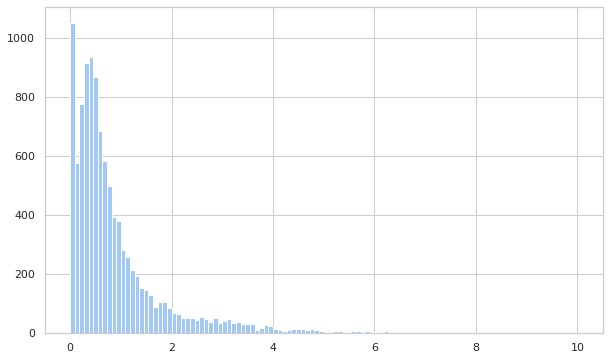

In [17]:
b_df.TripDistance.hist(bins=np.linspace(0,10,111))

## Company 'A' Data Load

In [19]:
a_df = pd.DataFrame()
df_list = []
for i in range(1,6):
  df_list.append(pd.read_csv("drive/MyDrive/data_exercise/company_a_{}.csv".format(i), parse_dates=True, infer_datetime_format=True))

In [20]:
a_df = pd.concat(df_list).reset_index()
del a_df['index']

In [21]:
#df = b_df.copy()

## Processing and Cleaning DataFrame:
* Remove infinite values
* keep Latitude < 38.75 and > 37.75
* keep Longitude < -85.16 and > -86.36
* Remove Duration = 0 and Distance = 0
* Remove Distance <= 0
* Remove Distance > 50 mi (2*Range of battery on E-Scooter)
* Remove Duration > 480 minutes (4 hours)

In [22]:
days_of_week = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
months_of_year = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
days_in_month = {'Jan':31,'Feb':28,'Mar':31,'Apr':30,'May':31,'Jun':30,'Jul':31,'Aug':31,'Sep':30,'Oct':31,'Nov':30,'Dec':31} 


In [24]:
def process_and_clean_df(df):
  df = df.dropna()
  try:
    df["StartTime"] = pd.to_datetime(df["StartTime"]).apply(lambda x: x.to_pydatetime())
    df["EndTime"] = pd.to_datetime(df.EndTime).apply(lambda x: x.to_pydatetime())
    df['StartDateTime'] = df['StartTime'].copy()
    df['StartTime'] = df['StartTime'].apply(lambda x: x.to_pydatetime().time())
    df['EndDateTime'] = df['EndTime'].copy()
    df['EndTime'] = df['EndTime'].apply(lambda x: x.to_pydatetime().time())
  except Exception as e:
    print(e)
    pass #dataframe B has a little different format
  df['Duration'] = (df.EndDateTime-df.StartDateTime).apply(lambda x: x.total_seconds()/60)

  df = df[(df['StartLongitude'] > -86.36) & (df['StartLongitude'] < -85.15)& (df['EndLongitude'] > -86.36)& (df['EndLongitude'] < -85.15)]
  df = df[(df['StartLatitude'] > 37.75) & (df['StartLatitude'] < 38.75 ) & (df['EndLatitude'] > 37.75) & (df['EndLatitude'] < 38.75)].reset_index()
  del df['index']

  df['Speed'] = 60*df['TripDistance']/df['Duration']
  df = df[(df['Speed'] > -np.inf) & (df['Speed'] < np.inf)].reset_index()
  del df['index']

  df = df[(df['Duration'] >= 0) & (df['Duration'] < 480) & (df['TripDistance'] > 0)& (df['TripDistance'] < 40)]
  df = df[(df['Speed'] > 0) & (df['Speed'] < 50)].reset_index()
  del df['index']

  df['Weekday'] = df.StartDateTime.apply(lambda tt: tt.weekday())
  df['Month'] = df.StartDateTime.apply(lambda tt: tt.month)
  df['Year'] = df.StartDateTime.apply(lambda tt: tt.year)

  SLDistance = []
  for i in tqdm(range(df.shape[0])):
    SLDistance.append(distance.distance((df['StartLatitude'].values[i],df['StartLongitude'].values[i]), (df['EndLatitude'].values[i],df['EndLongitude'].values[i])).miles)
  df['SLDistance'] = SLDistance
  df['MHDistance'] = np.abs(df['EndLatitude']-df['StartLatitude'])+np.abs(df['EndLongitude']-df['StartLongitude'])

  return df

In [ ]:
b_df = process_and_clean_df(b_df);
a_df = process_and_clean_df(a_df);

In [165]:
a_df.head()

,TripID,ScooterID,StartTime,EndTime,StartLatitude,StartLongitude,EndLatitude,EndLongitude,TripDistance,StartDateTime,...,Weekday,Month,Year,SLDistance,MHDistance,geometry,Date,Hour,Minute,Location
0,0e56a534-66f4-448b-8eaa-beab76509955,5bc901d7-b714-4c57-a614-3d7193da825a,10:24:00,10:26:00,38.25,-85.76,38.25,-85.76,0.04,2018-08-09 10:24:00,...,3,8,2018,0.000000,0.00,POINT (-85.76000 38.25000),2018-08-09,10,24,"(38.25, -85.76)"
1,d9280fb0-8135-4750-9c71-c610789ba005,3d1905ec-85be-4773-9fe2-34421073363f,10:26:00,10:56:00,38.25,-85.74,38.26,-85.77,1.98,2018-08-09 10:26:00,...,3,8,2018,1.771407,0.04,POINT (-85.74000 38.25000),2018-08-09,10,26,"(38.25, -85.74)"
2,48fa27f3-3b19-4f0e-8665-ee0b188445fd,5bc901d7-b714-4c57-a614-3d7193da825a,10:26:00,10:35:00,38.25,-85.76,38.25,-85.76,0.06,2018-08-09 10:26:00,...,3,8,2018,0.000000,0.00,POINT (-85.76000 38.25000),2018-08-09,10,26,"(38.25, -85.76)"
3,6321b580-9055-4418-8c17-1d39a4d49027,4d49088f-4038-4dfb-9d55-e58a157d56d5,10:37:00,10:56:00,38.25,-85.74,38.26,-85.77,1.85,2018-08-09 10:37:00,...,3,8,2018,1.771407,0.04,POINT (-85.74000 38.25000),2018-08-09,10,37,"(38.25, -85.74)"
4,d05bf0bb-f6ee-489e-a32c-a93e15b626f8,e398ff1b-5d6b-4f15-b493-a988c7ab07b6,10:41:00,10:47:00,38.26,-85.75,38.26,-85.76,0.35,2018-08-09 10:41:00,...,3,8,2018,0.543833,0.01,POINT (-85.75000 38.26000),2018-08-09,10,41,"(38.26, -85.75)"


In [166]:
b_df.head()

,TripID,StartTime,EndTime,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,StartDateTime,EndDateTime,Duration,Speed,Weekday,Month,Year,SLDistance,MHDistance
0,26559444,12:41:26,12:45:40,0.237364,38.23,-85.75,38.23,-85.76,2018-12-02 12:41:26+00:00,2018-12-02 12:45:40+00:00,4.233333,3.364220,6,12,2018,0.544057,0.01
1,26559031,12:39:24,12:41:49,0.067730,38.26,-85.75,38.26,-85.76,2018-12-02 12:39:24+00:00,2018-12-02 12:41:49+00:00,2.416667,1.681563,6,12,2018,0.543833,0.01
2,26552748,12:08:07,12:18:29,1.582636,38.21,-85.75,38.23,-85.75,2018-12-02 12:08:07+00:00,2018-12-02 12:18:29+00:00,10.366667,9.159953,6,12,2018,1.379452,0.02
3,26559594,12:42:16,12:56:58,0.978662,38.26,-85.76,38.26,-85.76,2018-12-02 12:42:16+00:00,2018-12-02 12:56:58+00:00,14.700000,3.994539,6,12,2018,0.000000,0.00
4,26557132,12:30:01,12:48:30,0.022991,38.22,-85.75,38.23,-85.76,2018-12-02 12:30:01+00:00,2018-12-02 12:48:30+00:00,18.483333,0.074632,6,12,2018,0.878499,0.02


In [167]:
# Operations:
# Rides per day, hour
# Peak time, graph of rides over time
# peak areas
# Overall range
# distance per ride, over time
# scooter wear/tear
# distances traveled by geography

In [168]:
a_df['StartLatitude'].describe()

count    50830.000000
mean        38.243597
std          0.016080
min         38.100000
25%         38.230000
50%         38.250000
75%         38.260000
max         38.330000
Name: StartLatitude, dtype: float64

In [169]:
a_df['StartLongitude'].describe()

count    50830.000000
mean       -85.745584
std          0.020327
min        -85.900000
25%        -85.760000
50%        -85.750000
75%        -85.740000
max        -85.490000
Name: StartLongitude, dtype: float64

In [170]:
b_df['StartLatitude'].describe()

count    10188.000000
mean        38.233426
std          0.018329
min         38.090000
25%         38.220000
50%         38.230000
75%         38.250000
max         38.320000
Name: StartLatitude, dtype: float64

In [171]:
b_df['StartLongitude'].describe()

count    10188.000000
mean       -85.753868
std          0.014514
min        -85.810000
25%        -85.760000
50%        -85.760000
75%        -85.750000
max        -85.560000
Name: StartLongitude, dtype: float64

## Look at the Geography of both Company's Trips

In [71]:
#mp = gpd.read_file('tl_2016_21_cousub.shp')
mp = gpd.read_file('/content/tl_2019_us_zcta510.shp')
kp = mp.copy()

In [72]:
mp.INTPTLAT = mp.INTPTLAT10.astype(float)
mp.INTPTLON = mp.INTPTLON10.astype(float)
mp = mp[(mp.INTPTLON >= -86) & (mp.INTPTLON <= -85.4) & (mp.INTPTLAT < 38.75) & (mp.INTPTLAT >= 38)].reset_index()
del mp['index']

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:199: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


In [73]:
kp.INTPTLAT = kp.INTPTLAT10.astype(float)
kp.INTPTLON = kp.INTPTLON10.astype(float)
kp = kp[(kp.INTPTLON >= -86.5) & (kp.INTPTLON <= -85) & (kp.INTPTLAT < 39) & (kp.INTPTLAT >= 37.75)].reset_index()
del kp['index']

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:199: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


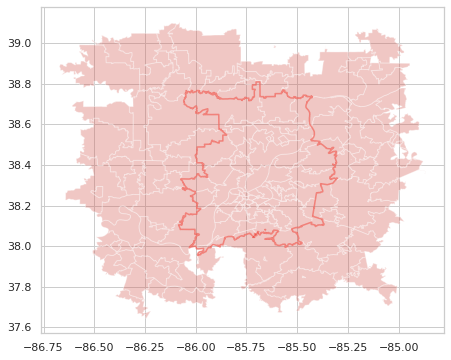

In [74]:
ax = kp.plot(alpha=0.35, color='#d66058', zorder=1)
gpd.GeoSeries(mp['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)


In [75]:
#shp_path = 'tl_2016_21_cousub.shp'
#sf = shp.Reader(shp_path)


In [76]:
df = a_df.copy()

In [77]:
cols_js = ['TripID', 'ScooterID', 'StartTime', 'EndTime', 'StartLatitude',
       'StartLongitude', 'EndLatitude', 'EndLongitude', 'TripDistance',
       'StartDateTime', 'EndDateTime', 'Weekday', 'Month', 'Year', 'Duration',
       'SLDistance', 'MHDistance', 'geometry']
cols_dp = [ 'ScooterID', 'EndLatitude', 'EndLongitude', 'TripDistance',
       'StartDateTime', 'EndDateTime', 'Duration',
       'SLDistance', 'MHDistance']

In [78]:
def p_df_TO_g_df(df):
  s_xy = gpd.GeoSeries.from_xy(df.StartLongitude, df.StartLatitude)
  e_xy = gpd.GeoSeries.from_xy(df.EndLongitude, df.EndLatitude)
  s_gs = gpd.points_from_xy(df.StartLongitude, df.StartLatitude)
  e_gs = gpd.points_from_xy(df.EndLongitude, df.EndLatitude)
  g_df = gpd.GeoDataFrame(df,geometry=s_gs,crs="epsg:4326")
  g_df['StartDateTime'] = g_df['StartDateTime'].apply(lambda t: t.to_pydatetime())
  g_df['EndDateTime'] = g_df['EndDateTime'].apply(lambda t: t.to_pydatetime())
  mp.crs = {'init':"epsg:4326"}
  g_df.crs = {'init':"epsg:4326"}
  g_df = g_df.set_geometry(s_gs)
  return g_df, e_gs, s_gs 

In [79]:
a_g_df, a_e_gs, a_s_gs = p_df_TO_g_df(a_df)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [80]:
b_g_df, b_e_gs, b_s_gs = p_df_TO_g_df(b_df)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [81]:
a_g_df = a_g_df.set_geometry(a_s_gs)
b_g_df = b_g_df.set_geometry(b_s_gs)

In [82]:
g_df, e_gs, s_gs = a_g_df, a_e_gs, a_s_gs

## Trips on the Map: Kentucky/Indiana Border

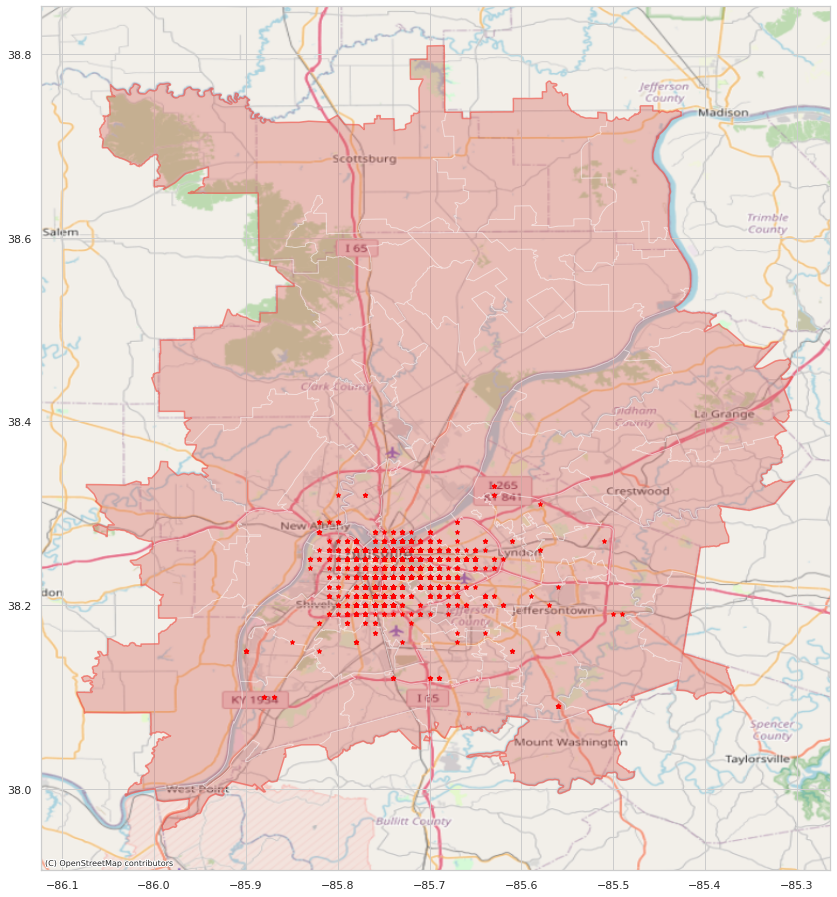

In [83]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_axes((1,1,1,1))
ax = mp.plot(ax = ax, alpha=0.35, color='#d66058', zorder=1)
gpd.GeoSeries(mp['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
ax = a_g_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Company A', zorder=3)
ax = b_g_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Company B', zorder=4)
ctx.add_basemap(ax, crs=g_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


In [84]:
ct_start = Counter(zip(df.StartLatitude,df.StartLongitude))

### Analyze Distance/LatLong Trip Parameters

In [85]:
df = a_df.copy()

In [86]:
def scatter_df(df,column_x,column_y,xlim=None,ylim=None,new_fig=True,c='blue',m='o'):
  ct_end = Counter(zip(df[column_x],df[column_y]))
  if new_fig: fig = plt.figure(figsize=(12,16))
  #axs = fig.add_subplot(111)
  #plt.scatter(df['StartLatitude'],df['StartLongitude'], s=[(np.log(ct_start[(i,j)]) + 1)**2 for i,j in zip(df.StartLatitude,df.StartLongitude)],\
  #            c='red',marker='o')
  plt.scatter(df[column_x],df[column_y], s=[(5e4/df.shape[0])*(np.log(ct_end[(i,j)]) + 1)**2 for i,j in zip(df.EndLatitude,df.EndLongitude)],\
              c=c,marker=m)
  if xlim:plt.xlim(xlim)
  if ylim:plt.ylim(ylim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


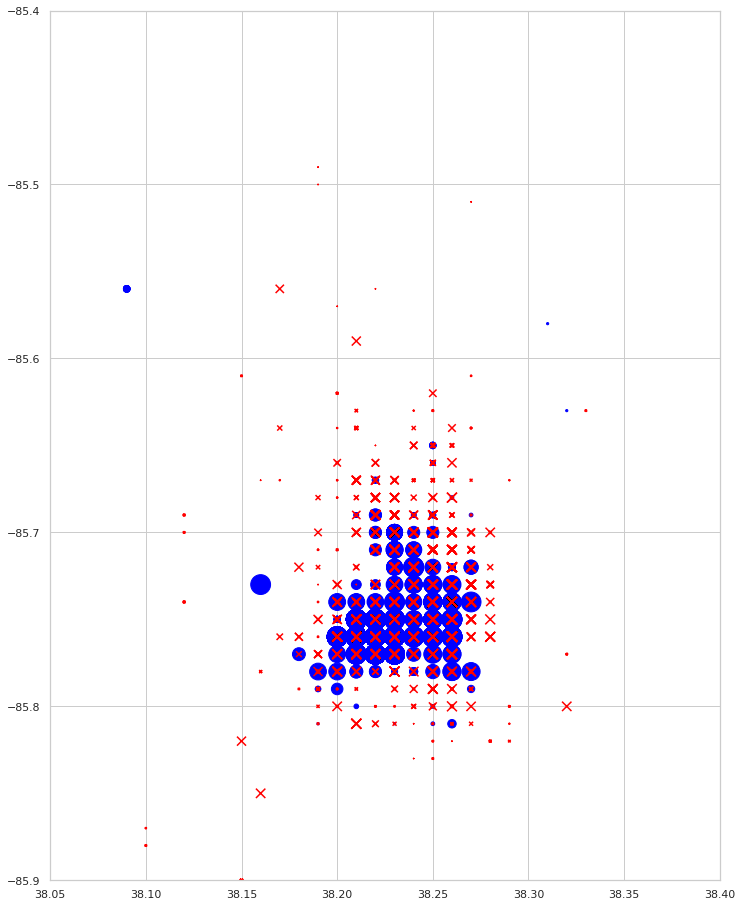

In [87]:
scatter_df(b_df,'StartLatitude','StartLongitude',(38.05,38.4),(-85.9,-85.4))
scatter_df(a_df,'StartLatitude','StartLongitude',(38.05,38.4),(-85.9,-85.4),False,'red','x')

In [88]:
sum(df['Duration'] <= 0), sum(df['TripDistance']<=0), sum(df['Speed'] < 0)

(0, 0, 0)

In [89]:
sum(df['Duration'] == 0), sum(df['TripDistance'] ==0), sum(df['Speed'] == 0)

(0, 0, 0)

In [90]:
df['Speed'].describe()

count    50830.000000
mean         5.734270
std          2.700626
min          0.015789
25%          3.763636
50%          5.600000
75%          7.500000
max         47.200000
Name: Speed, dtype: float64

In [49]:
df.Speed.describe()

count    50830.000000
mean         5.734270
std          2.700626
min          0.015789
25%          3.763636
50%          5.600000
75%          7.500000
max         47.200000
Name: Speed, dtype: float64

Text(0, 0.5, 'Trips')

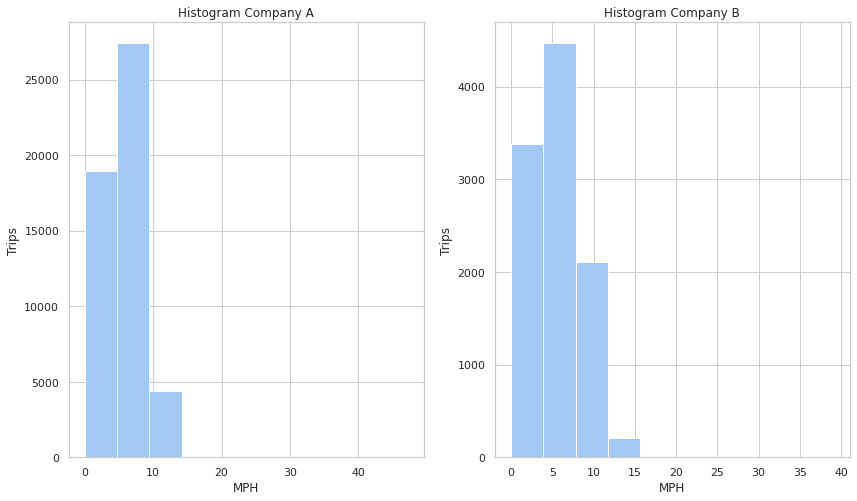

In [104]:
plt.figure(figsize=(14,8))
plt.subplot(121)
a_df.Speed.hist()
plt.title("Histogram Company A")
plt.xlabel("MPH")
plt.ylabel("Trips")
plt.subplot(122)
b_df.Speed.hist()
plt.title("Histogram Company B")
plt.xlabel("MPH")
plt.ylabel("Trips")

In [52]:
import seaborn as sns
import matplotlib as mpl

In [53]:
import geopy

### Company A - Start/End Lat/Long 2d Hist Lat X Long

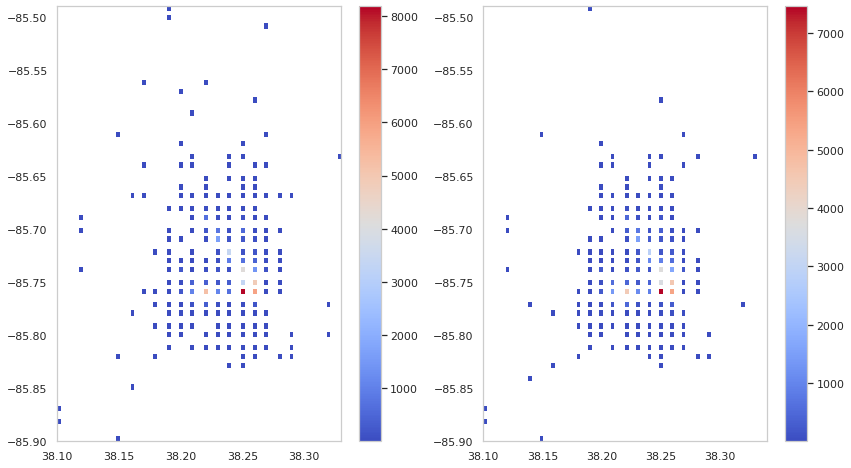

In [105]:
fig = plt.figure(figsize=(14,8))
plt.subplot (121)
plt.hist2d(a_df['StartLatitude'],a_df['StartLongitude'],(100,100),cmin=1,cmap='coolwarm')
plt.colorbar()
plt.subplot(122)
plt.hist2d(a_df['EndLatitude'],a_df['EndLongitude'],(100,100),cmin=2,cmap='coolwarm')
plt.colorbar()
#plt.legend(labels=['StartLatitude', 'StartLongitude'],loc='upper right',)
#plt.legend(labels=['StartLatitude', 'StartLongitude'],loc='upper right',)

### Company B - Start/End Lat/Long 2d Hist Lat X Long

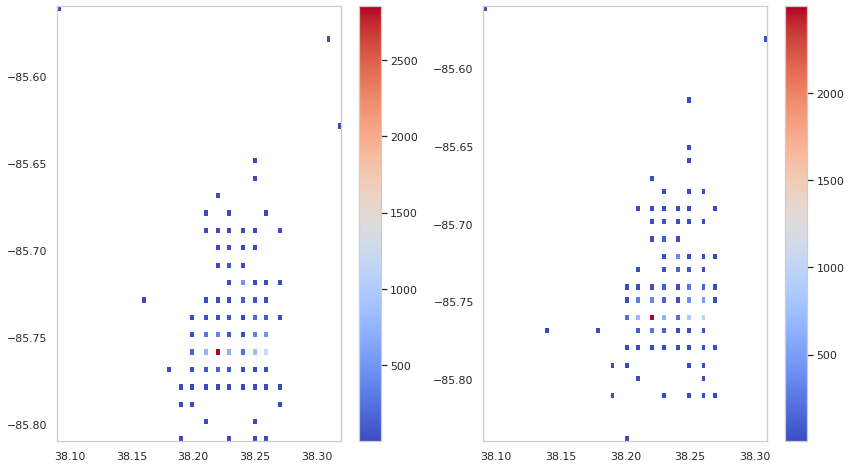

In [106]:
fig = plt.figure(figsize=(14,8))
plt.subplot (121)
plt.hist2d(b_df['StartLatitude'],b_df['StartLongitude'],(100,100),cmin=1,cmap='coolwarm')
plt.colorbar()
plt.subplot(122)
plt.hist2d(b_df['EndLatitude'],b_df['EndLongitude'],(100,100),cmin=2,cmap='coolwarm')
plt.colorbar()
#plt.legend(labels=['StartLatitude', 'StartLongitude'],loc='upper right',)
#plt.legend(labels=['StartLatitude', 'StartLongitude'],loc='upper right',)

### Comparison of End Locations Company A (red) Company B (blue)

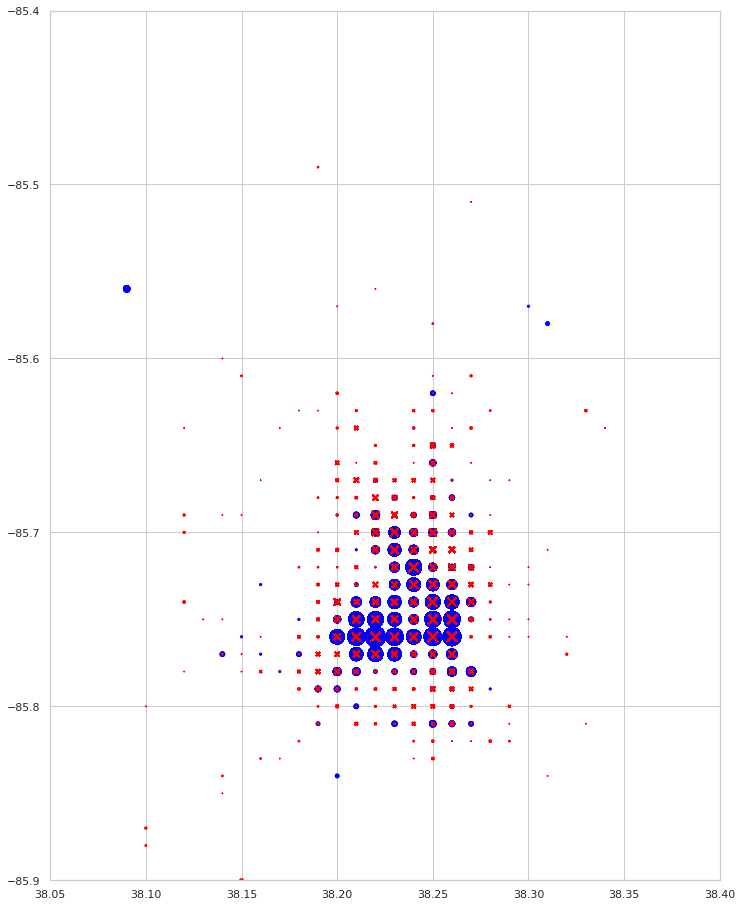

In [56]:
scatter_df(b_df,'EndLatitude','EndLongitude',(38.05,38.4),(-85.9,-85.4),True,'blue','o')
scatter_df(a_df,'EndLatitude','EndLongitude',(38.05,38.4),(-85.9,-85.4),False,'red','x')

In [57]:
def monthly_chart(df):
  plt.figure()
  month_count = Counter(df.Month)
  months_present = np.sort(df.Month.unique())
  plt.bar(list(range(1,len(month_count)+1)),[month_count[m] for m in months_present] )
  plt.xticks(list(range(1,len(months_present) + 1)),labels=[months_of_year[m-1] for m in months_present])
  plt.xlabel("Month")
  plt.ylabel("Total Trips")
  plt.title("Monthly Trips");

In [58]:
def daily_chart(df, title=None):
  day_count = Counter(df.Weekday)
  plt.bar(list(range(1,8)),[day_count[day] for day in range(7)] )
  plt.xticks(list(range(1,8)),labels=days_of_week)
  plt.xlabel("Day")
  plt.ylabel("Trips")
  if title: plt.title(title)

def bar_chart(occurance_list,key=lambda x : x.hour,lim=24, title="Histogram", xlabel="Hour", ylabel="Trips"):
    dlist = [key(t) for t in occurance_list]
    numbers=[x for x in range(1,lim+1)]
    d = Counter(dlist)
    dd = {}
    for x in range(1,lim+1):
      dd[x] = d[x]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,lim)
    plt.bar(numbers, list(map(lambda x: x[1], sorted(dd.items(),key=lambda x: x[0]))))
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)

In [59]:
def hourly_chart(occurance_list, title="Histogram", xlabel="Hour", ylabel="Trips"):
    hour_list = [t.hour for t in occurance_list]
    numbers=[x for x in range(0,24)]
    d = Counter(hour_list)
    dd = {}
    for x in range(24):
      dd[x] = d[x]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.bar(numbers, list(map(lambda x: x[1], sorted(dd.items(),key=lambda x: x[0]))))
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)

### Daily Trips

Company A

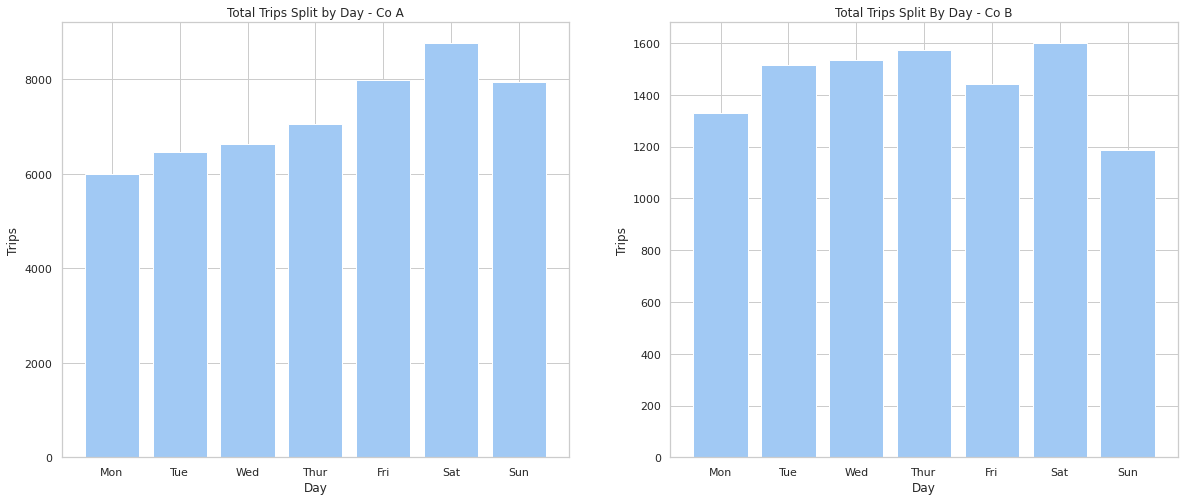

In [108]:
plt.figure(figsize=(20,8))
plt.subplot(121)
daily_chart(a_df,'Total Trips Split by Day - Co A')
plt.subplot(122)
daily_chart(b_df,'Total Trips Split By Day - Co B')


In [110]:
a_df.Year.unique()

array([2018])

In [109]:
b_df.Year.unique()

array([2018, 2019])

### Monthly Trips

Company B

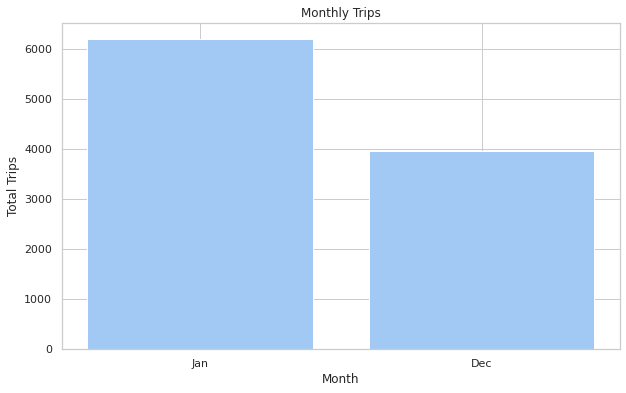

In [111]:
monthly_chart(b_df)

Company A

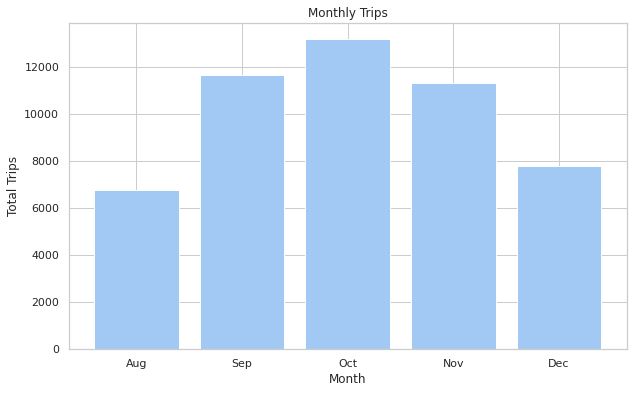

In [112]:
monthly_chart(a_df)

### Daily Rides by Month

Company A

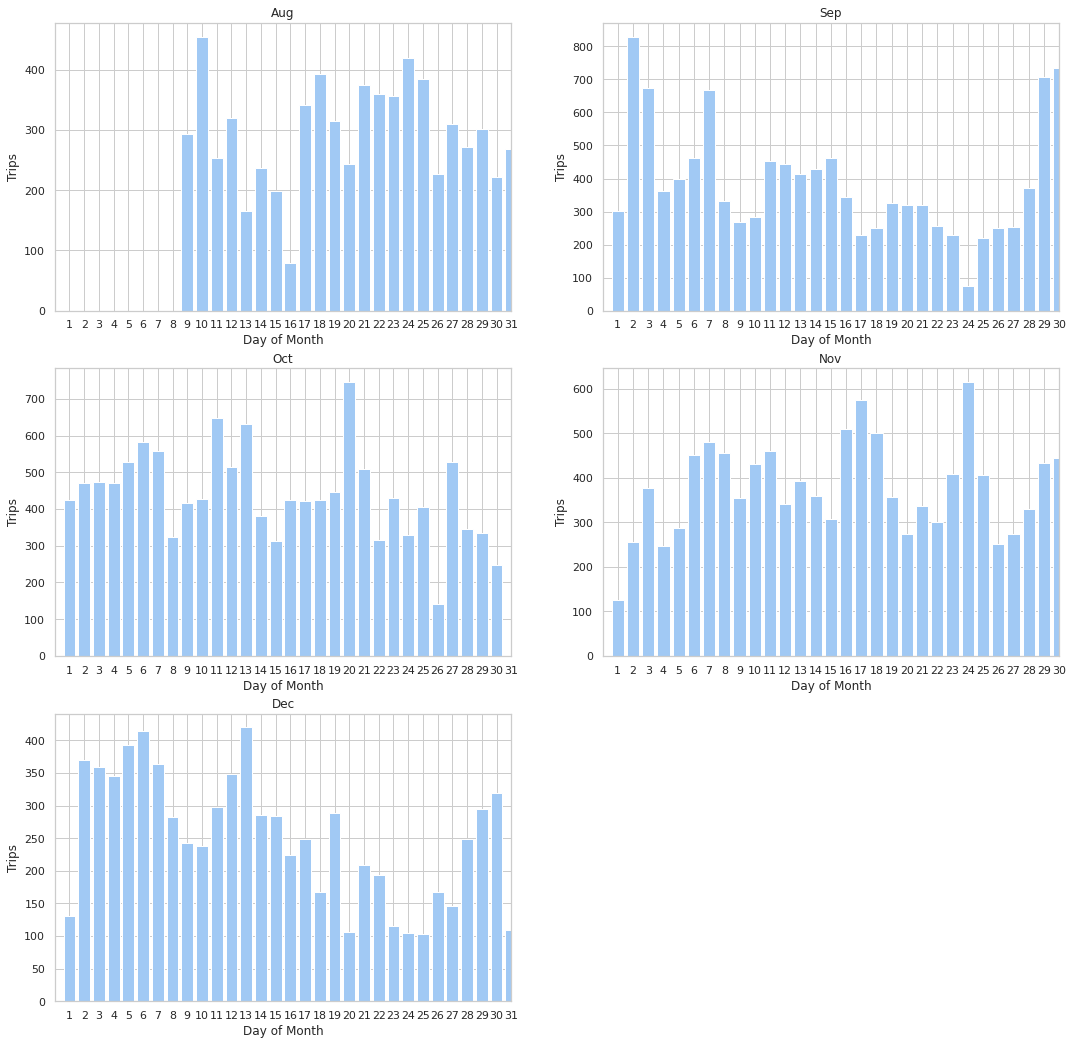

In [96]:
plt.figure(figsize=(18,18))
for i,month in enumerate(a_df.Month.unique()):
  plt.subplot(320+i+1)
  bar_chart(a_df[a_df.Month==month].StartDateTime,lambda x: x.day,lim=days_in_month[months_of_year[month-1]],xlabel='Day of Month',title=months_of_year[month-1])

Company B

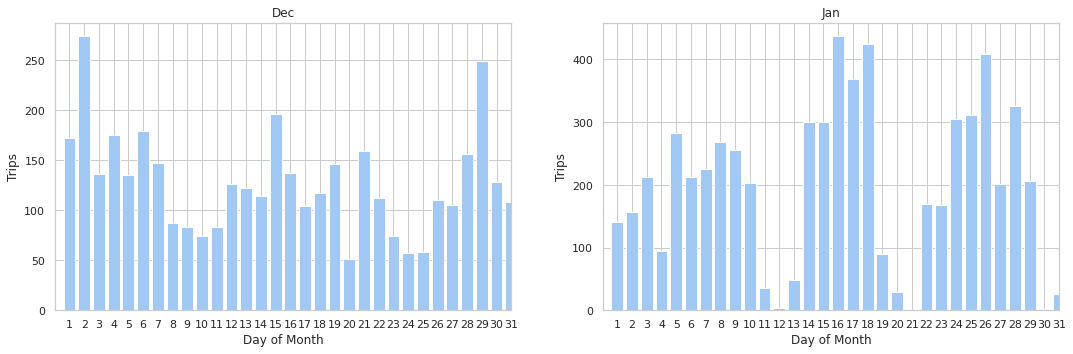

In [114]:
plt.figure(figsize=(18,18))
for i,month in enumerate(b_df.Month.unique()):
  plt.subplot(320+i+1)
  bar_chart(b_df[b_df.Month==month].StartDateTime,lambda x: x.day,lim=days_in_month[months_of_year[month-1]],xlabel='Day of Month',title=months_of_year[month-1])

### Trips by Day of Week Every Month

Company A

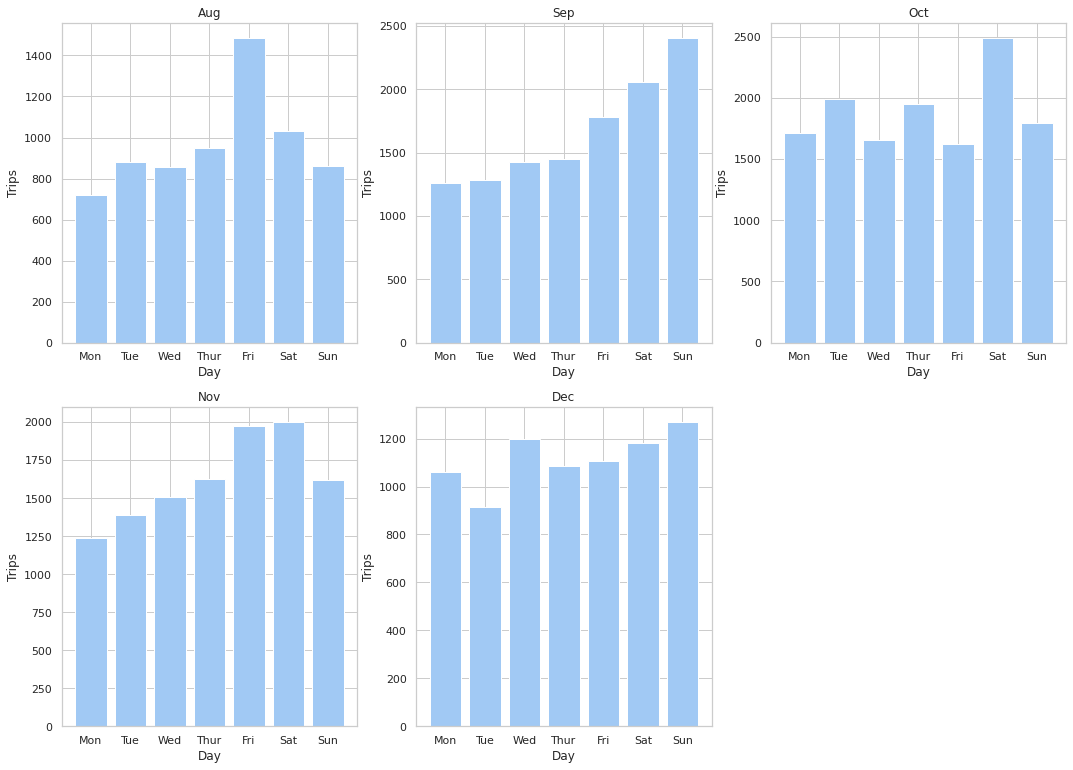

In [100]:
plt.figure(figsize=(18,20))
for n,month in enumerate(a_df.Month.unique()):
  plt.subplot(330+n+1)
  daily_chart(a_df[a_df.Month==month], months_of_year[month-1])


Company B

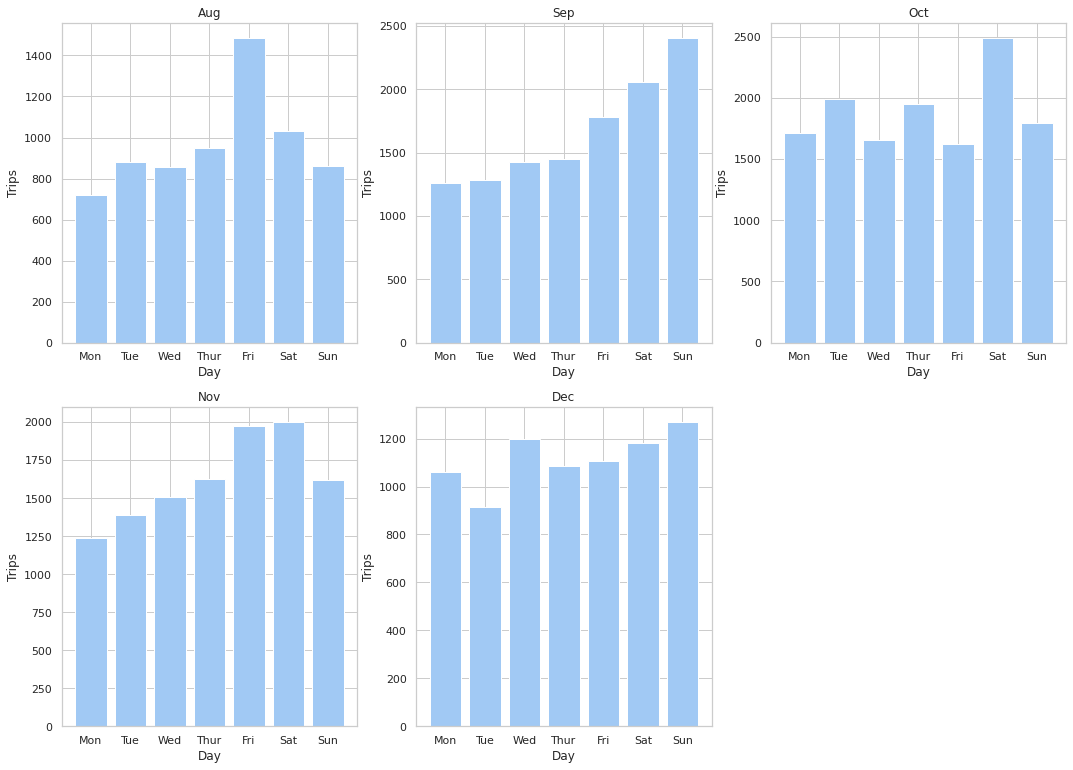

In [101]:
plt.figure(figsize=(18,20))
for n,month in enumerate(b_df.Month.unique()):
  plt.subplot(330+n+1)
  daily_chart(df[b_df.Month==month], months_of_year[month-1])


### Hourly Trips by Month

Company B

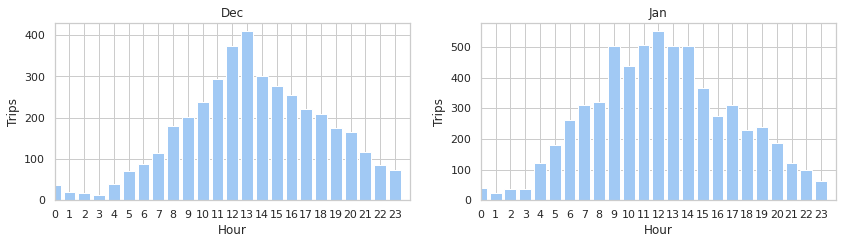

In [116]:
plt.figure(figsize=(14,15))
for n,month in enumerate(b_df.Month.unique()):
  plt.subplot(420+n+1)
  hourly_chart(b_df[b_df.Month==month].StartDateTime, months_of_year[month-1],'Hour')


Company A

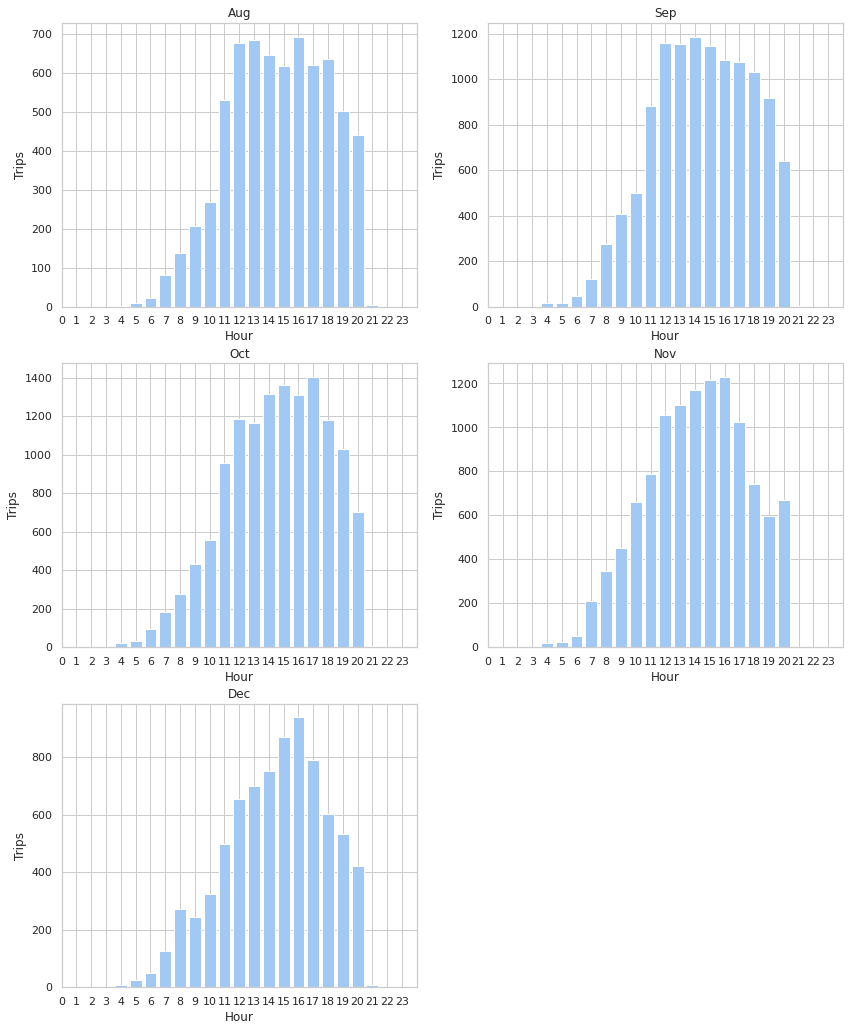

In [103]:
plt.figure(figsize=(14,24))
for n,month in enumerate(a_df.Month.unique()):
  plt.subplot(420+n+1)
  hourly_chart(a_df[a_df.Month==month].StartDateTime, months_of_year[month-1],'Hour')


### Hourly Trips by Day of Week

Company A

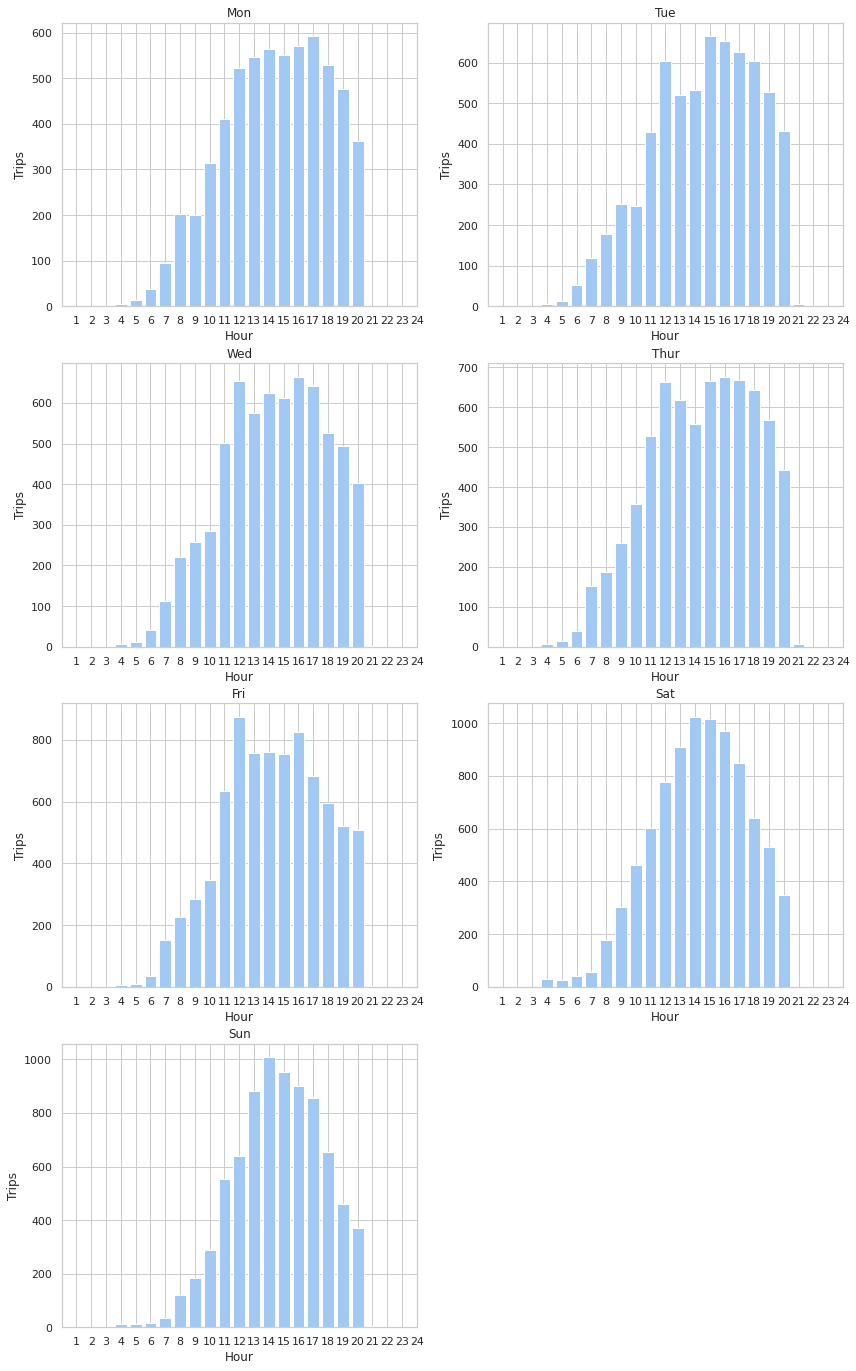

In [118]:
plt.figure(figsize=(14,24))
for day in range(7):
  plt.subplot(420+day+1)
  bar_chart(a_df[a_df.Weekday==day].StartDateTime, title = days_of_week[day])


Company B

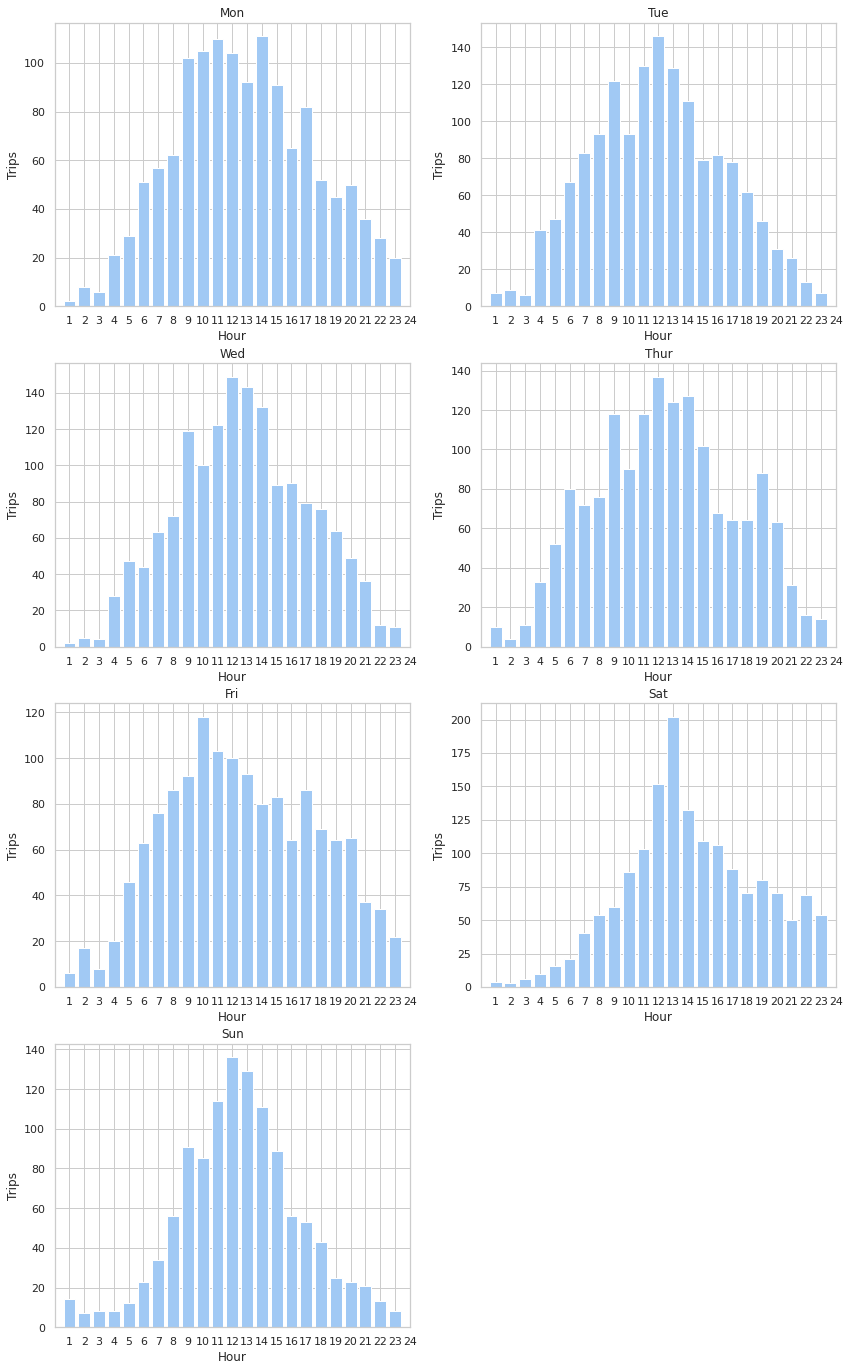

In [119]:
plt.figure(figsize=(14,24))
for day in range(7):
  plt.subplot(420+day+1)
  bar_chart(b_df[b_df.Weekday==day].StartDateTime, title = days_of_week[day])


### Trip Duration X Distance Hist

Text(0, 0.5, 'TripDistance (mi)')

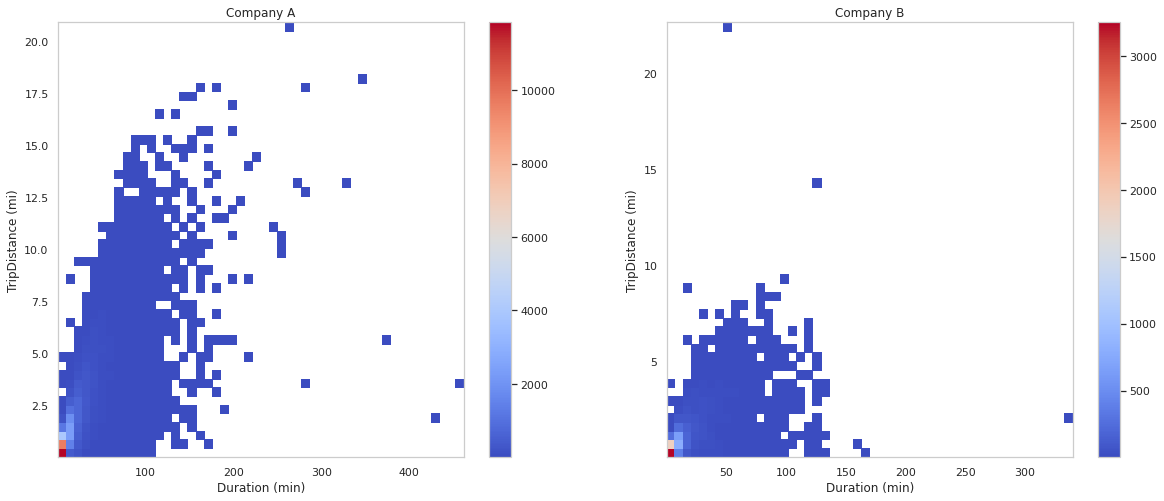

In [121]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title("Company A")
plt.xlabel("Duration (min)")
plt.ylabel("TripDistance (mi)")

plt.hist2d(a_df.Duration,a_df.TripDistance,bins=(50,50),cmin=1, cmap='coolwarm')
plt.colorbar()

plt.subplot(122)
plt.hist2d(b_df.Duration,b_df.TripDistance,bins=(50,50),cmin=1, cmap='coolwarm')
plt.colorbar()
plt.title("Company B")
plt.xlabel("Duration (min)")
plt.ylabel("TripDistance (mi)")


### How Far do Scooters Start the day from the Last Trip the previous Day

Company A

In [123]:
lats = []
longs = []
for s_id in a_df.ScooterID.unique(): 
  s_df = a_df[a_df.ScooterID==s_id]
  idx = np.where(np.diff(s_df.StartDateTime.apply(lambda x:x.day).values) != 0)[0]
  lats.append(s_df.EndLatitude.values[idx] - s_df.StartLatitude.values[idx+1])
  s_df.StartLatitude.values[idx+1] - s_df.StartLatitude.values[idx]
  #geopy.distance()
  longs.append(s_df.EndLongitude.values[idx] - s_df.StartLongitude.values[idx+1])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([  3.,   0.,   0.,   7.,  14., 114., 368., 225.,  44.,  18.,  12.,
          6.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([-0.04 , -0.034, -0.028, -0.022, -0.016, -0.01 , -0.004,  0.002,
         0.008,  0.014,  0.02 ,  0.026,  0.032,  0.038,  0.044,  0.05 ,
         0.056,  0.062,  0.068,  0.074,  0.08 ,  0.086,  0.092,  0.098,
         0.104,  0.11 ]),
 <a list of 25 Patch objects>)

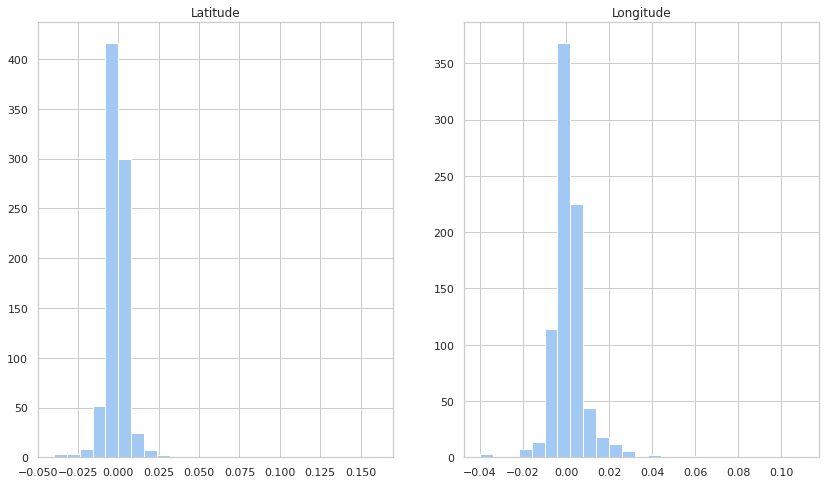

In [124]:
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.title("Latitude")
plt.hist(list(map(np.mean,lats)),bins=25)#,label='Latitude')
plt.subplot(122)
plt.title("Longitude")
plt.hist(list(map(np.mean,longs)),bins=25)#,lebel='Longitude')
#plt.legend(labels=['Latitude','Longitude'])

## Calculate Utilization Rate
* Utilization Rate is calculated as the ratio of the total time all of the scooters were used divided by the potential time they could have been used

In [125]:
def more_proc(df):
  df['Date'] = df.StartDateTime.apply(lambda x: x.date())#.unique()
  df['Hour'] = df.StartDateTime.apply(lambda x: x.hour)#.unique()
  df['Minute'] = df.StartDateTime.apply(lambda x: x.minute)#.unique()
  df['Location'] = list(zip(df.StartLatitude , df.StartLongitude))
  return df

In [126]:
a_df = more_proc(a_df)

In [131]:
print("Number of Scooters: ",a_df.ScooterID.unique().size)
print("Utilization in Minutes: ",a_df.Duration.sum())
print("Potential Utilization Time: ", a_df.ScooterID.unique().size*a_df.Date.unique().size*(60*20))
print("Utilization Rate %: ", 100*a_df.Duration.sum()/(a_df.ScooterID.unique().size*a_df.Date.unique().size*(60*24)))

Number of Scooters:  844
Utilization in Minutes:  869481.0
Potential Utilization Time:  145843200
Utilization %:  0.49681267278830965


Assuming Company B has a similar Utilization Rate

In [136]:
b_df = more_proc(b_df)

In [140]:
print("Total Potential Time: ", b_df.Duration.sum()/0.00496)
print("Potential Days: ", b_df.Date.unique().size)
print("Potential Time per Scooter (60*24*): ", b_df.Date.unique().size*60*24)
print("Number of Scooters: " , (b_df.Duration.sum()/0.00496)/(b_df.Date.unique().size*60*24))

Total Potential Time:  27800295.69892473
Potential Days:  61
Potential Time per Scooter (60*24*):  87840
Number of Scooters:  316


### Extra Analysis: Look for relationships in Company A data btw Trips/Unit Time, Location, Scooter Number

In [142]:
rpd = []
rph = []
df = a_df
#plt.figure(figsize=(21,40))
for i,dt in enumerate(df.Date.unique()):#[:10]):
  d_df = df[df.Date==dt]#.copy().reset_index()
  rpd.append((d_df.shape[0],d_df.ScooterID.unique().size))
  for h in range(24):
    h_df = d_df[d_df.Hour==h]#.copy().reset_index()
    rph.append((h_df.shape[0],h_df.ScooterID.unique().size))

#### Scatter plot of Scooters vs Rides per Day x Rides per Hour

Text(0, 0.5, 'Scooters Used')

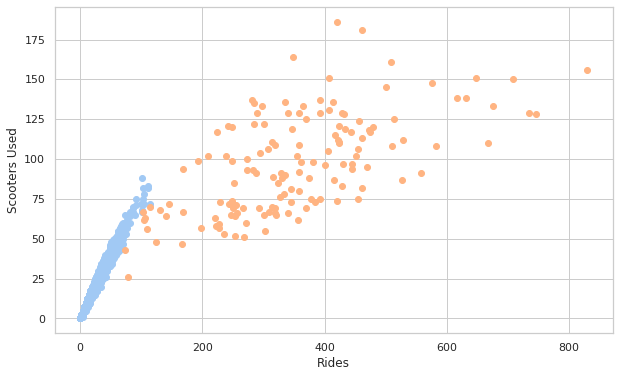

In [144]:
plt.scatter([a[0] for a in rph],[a[1] for a in rph])
plt.scatter([a[0] for a in rpd],[a[1] for a in rpd])
plt.xlabel("Rides")
plt.ylabel("Scooters Used")

### Common Location between A/B

In [146]:
b_loc,a_loc = set(list(zip(b_df.StartLatitude , b_df.StartLongitude))), set(list(zip(a_df.StartLatitude , a_df.StartLongitude)))

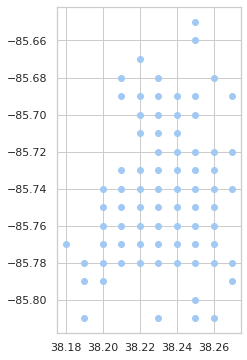

In [147]:
x,y = [],[]
z = [(x.append(xy[0]),y.append(xy[1])) for xy in list(a_loc.intersection(b_loc))]
z_series = gpd.GeoSeries.from_xy(x,y)
z_series.plot()

In [148]:
df = more_proc(a_df)

In [149]:
arpl = []
arpd = []
arph = []
x_data = []
for i,dt in enumerate(df.Date.unique()):#[:10]):
  d_df = df[df.Date==dt]#.copy().reset_index()
  arpd.append((d_df.shape[0],d_df.ScooterID.unique().size))
  for z in d_df.Location.unique():
    l_df = d_df[d_df['Location']==z]
    arpl.append((l_df.shape[0],l_df.ScooterID.unique().size))
    for h in range(24):
      h_df = l_df[l_df.Hour==h]#.copy().reset_index()
      arph.append((h_df.shape[0],h_df.ScooterID.unique().size))
      x_data.append((z[0],z[1],i,dt.day,h,h_df.shape[0],h_df.ScooterID.unique().size))

### Explore curve fitting for scooter number



> Really should actually be exploring a Simulation of Assigning a Scooter per trip and see how many are needed. 


In [150]:
poly_scoot_m,poly_scoot_b = np.polyfit([a[0] for a in arpl],[a[1] for a in arpl],1)

NameError: ignored

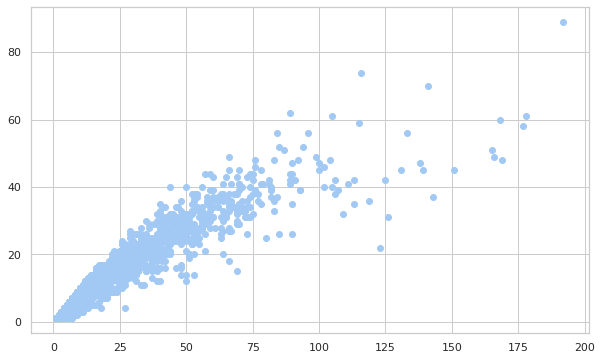

In [151]:
#plt.scatter([a[0] for a in arph],[a[1] for a in arph])
plt.scatter([a[0] for a in arpl],[a[1] for a in arpl])
plt.scatter([a[0] for a in arpl], [m*a[0] + b for a in arpl])

In [ ]:
rpd = []
rph = []
#plt.figure(figsize=(21,40))
for i,dt in enumerate(df.Date.unique()):#[:10]):
  d_df = df[df.Date==dt]#.copy().reset_index()
  rpd.append(d_df.shape[0])
  for h in range(24):
    h_df = d_df[d_df.Hour==h]#.copy().reset_index()
    rph.append(h_df.shape[0])

  #occurance_list = d_df.StartDateTime.apply(lambda x: x.hour)
  #for hr in range(24):
  #plt.subplot(430+i+1)
  #bar_chart(d_df.StartDateTime, title = str(dt))


In [152]:
max(rpd) #Max number of Rides in a Day for Company B

(830, 156)

## Deep Learning
> See if there is a more complex relationship btw location, time, trip number and scooter number (label)



In [ ]:
import tensorflow as tf

In [ ]:
X = np.vstack(x_data)
X,y = X[:,:-1],X[:,-1:]

In [ ]:
from tensorflow.keras import layers, Sequential

scooter_normalizer = layers.Normalization()
scooter_normalizer.adapt(X)


scooter_model = Sequential([
    scooter_normalizer,
    #layers.Dense(64, activation='relu'),
    #layers.Dropout(0.3),
    #layers.Dense(6, activation='relu'),
    layers.Dense(1)
])

scooter_model.compile(loss='mean_absolute_error', metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(0.1))



In [ ]:
history = scooter_model.fit(
    X,
    y,
    epochs=100,
    verbose=2,
    validation_split = 0.2)

In [ ]:
scooter_model.evaluate(X,y)

In [ ]:
X.shape,y.shape

Company B

In [ ]:
df = more_proc(b_df).copy()

In [ ]:
scoot_num = []
x_data = []
for i,dt in enumerate(df.Date.unique()):#[:10]):
  d_df = df[df.Date==dt]#.copy().reset_index()
  for z in d_df.Location.unique():
    l_df = d_df[d_df['Location']==z]
    for h in range(24):
      h_df = l_df[l_df.Hour==h]#.copy().reset_index()
      scoot_num.append(poly_scoot_m*h_df.shape[0] + poly_scoot_s)
      

In [ ]:
X[y.flatten()!=0].shape
inds = np.hstack([[0],np.where(np.diff(X[:,3])!=0)[0],[X.shape[0]-1]])
max_scoots = {}
for i in range(1,len(inds)):
  x = X[inds[i-1]:inds[i]]
  #print (x[:,3].min(),x[:,3].max())
  for h in np.unique(x[:,4]):
    max_scoots[(i,h)] = (x[x[:,4]==h][:,-1].sum())


Peak Trips per Day for Company *B*

## Company B Estimate - 317 Scooters

## Notes, Analysis and Conclusions.


* Based on the analysis of the presented data, Company A's fleet is under-utilize.
* According to industry research, utilization rate is between 2%-4%. However, Company A's utilization rate in this area is ~0.5%. This is defined (as total use time)/(potential use time) calculated over the number of scooters in the fleet. 
* However, for the ~850 odd scooters in Company A's fleet, almost all of them were used on the peak day (of the .
* Note that we only have record of those used at least once in the given time frame. It is assumed that there are no other vehicles in the fleet. I.E. the fleet size of Company A equals the number of unique ScooterIDs. 
* Company A was Closed on Halloween! OR the data is missing.
* Peak hours are in the afternoon with the apex between 12 and 2pm. Then a steady Decline. Company A and Company B share the same general trends given any Day. 
* However we see that utilization is more even over the month for Company A, likely due to the data collected during the winter (Dec and Jan) for Company B. 
* In addition, the fluctuation over the month is much larger in Company B.
* This is the opposite in the trips by day, where there isn't as much of a variation by Day(of week) as in Company A.
* Company A either has no data after 8pm or they are closed.
* The companies both operate in the same general geography, near the Indiana/Kentucky Border.